In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import librosa
import seaborn as sns

# Add digehealth_assessment folder to sys.path to allow imports from it
import sys
from pathlib import Path
digehealth_path = Path().resolve().parent / "digehealth_assessment"
if str(digehealth_path) not in sys.path:
    sys.path.append(str(digehealth_path))

from config import EXTERNAL_DATA_DIR, FIGURES_DIR
from preprocessing import load_and_normalize_wav

2025-08-21 17:59:04.538 | INFO     | config:<module>:11 - PROJ_ROOT path is: D:\Files\Projects\Code\digehealth-assessment


In [2]:
wav1 = EXTERNAL_DATA_DIR / "Tech Test" / "AS_1.wav"
wav2 = EXTERNAL_DATA_DIR / "Tech Test" / "23M74M.wav"
save = FIGURES_DIR / "wav_rms_subplots.png"

# Inspect waveforms

In [3]:
def compute_rms(signal: np.ndarray) -> float:
    return float(np.sqrt(np.mean(np.square(signal)))) if signal.size > 0 else 0.0


def plot_waveform_with_rms(ax, y: np.ndarray, sr: int, title: str):
    times = np.arange(len(y)) / float(sr)
    rms = compute_rms(y)

    ax.plot(times, y, color="steelblue", linewidth=0.8)
    ax.axhline(
        rms, color="crimson", linestyle="--", linewidth=1.2, label=f"RMS = {rms:.4f}"
    )
    ax.set_title(title)
    ax.set_xlabel("Time (s)")
    ax.set_ylabel("Amplitude")
    ax.legend(loc="upper right")
    ax.grid(True, alpha=0.2)

Saved figure to D:\Files\Projects\Code\digehealth-assessment\reports\figures\EDA_wav_rms_subplots.png


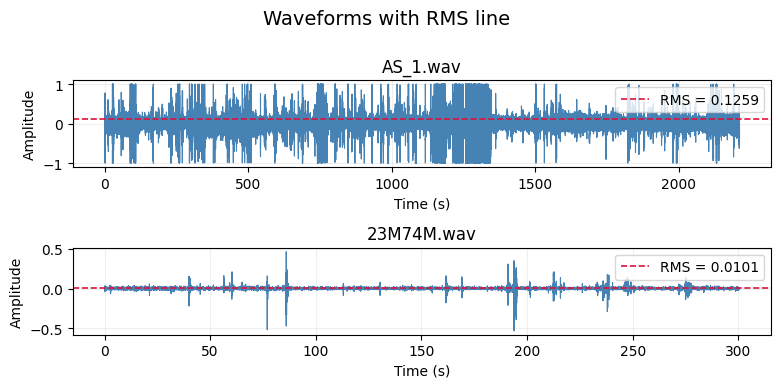

In [4]:
y1, sr1 = librosa.load(wav1, sr=None, mono=True) 
y2, sr2 = librosa.load(wav2, sr=None, mono=True)  

# Plot
fig, axes = plt.subplots(2, 1, figsize=(8, 4))
plot_waveform_with_rms(axes[0], y1, sr1, title=f"{wav1.name}")
plot_waveform_with_rms(axes[1], y2, sr2, title=f"{wav2.name}")
fig.suptitle("Waveforms with RMS line", fontsize=14)
fig.tight_layout(rect=[0, 0.02, 1, 0.98])

# Save and show
save_path = FIGURES_DIR / "EDA_wav_rms_subplots.png"
save_path.parent.mkdir(parents=True, exist_ok=True)
fig.savefig(save_path, dpi=150, bbox_inches="tight")
print(f"Saved figure to {save_path}")

plt.show()

Apply normalization:

Saved figure to D:\Files\Projects\Code\digehealth-assessment\reports\figures\EDA_wav_normalized_rms_subplots.png


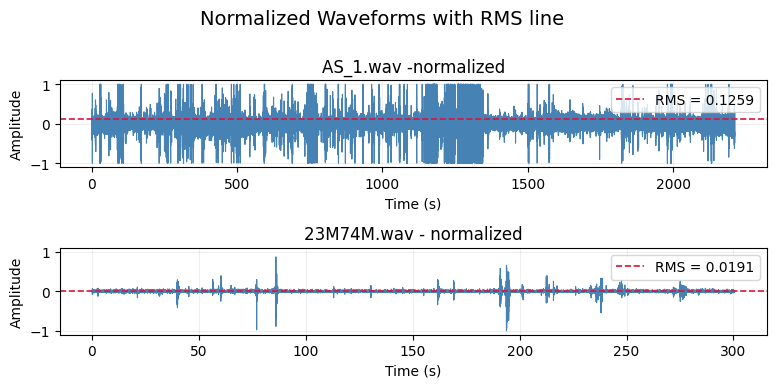

In [5]:
# Load audio and normalize
y1_norm, sr1 = load_and_normalize_wav(wav1)
y2_norm, sr2 = load_and_normalize_wav(wav2)

# Plot
fig, axes = plt.subplots(2, 1, figsize=(8, 4), sharey=True)
plot_waveform_with_rms(axes[0], y1_norm, sr1, title=f"{wav1.name} -normalized")
plot_waveform_with_rms(axes[1], y2_norm, sr2, title=f"{wav2.name} - normalized")
fig.suptitle("Normalized Waveforms with RMS line", fontsize=14)
fig.tight_layout(rect=[0, 0.02, 1, 0.98])

# Save and show
save_path = FIGURES_DIR / "EDA_wav_normalized_rms_subplots.png"
save_path.parent.mkdir(parents=True, exist_ok=True)
fig.savefig(save_path, dpi=150, bbox_inches="tight")
print(f"Saved figure to {save_path}")

plt.show()

Remarks: 
- AS_1 has a lower sample frequency than the other file
- AS_1 shows clipping 
- 23M74M has strong noise(?) events
- 


# Explore annotations

In [6]:
ann1 = EXTERNAL_DATA_DIR / "Tech Test" / "AS_1.txt"
ann2 = EXTERNAL_DATA_DIR / "Tech Test" / "23M74M.txt"

In [7]:
df1 = pd.read_csv(ann1, sep="\t", header=None, names=["start", "end", "label"])
print(df1.shape)
print(df1.head())
print("\n")
df2 = pd.read_csv(ann2, sep="\t", header=None, names=["start", "end", "label"])
print(df2.shape)
print(df2.head())

(1927, 3)
      start        end label
0  0.000000  17.019255     n
1  0.988978   1.242612     h
2  1.278083   1.447401     b
3  1.496558   1.644029     b
4  1.731420   1.851581     b


(522, 3)
      start       end label
0  1.124516  1.186244    sb
1  1.680065  1.733741    sb
2  1.918924  1.986019    sb
3  2.018225  2.267819    mb
4  2.565722  2.611347    sb


Observations:
- AS_1 has more events

In [8]:
# Calc event duration
for df in [df1, df2]:
    df['duration'] = df['end']-df['start']
    
df1.head()

,start,end,label,duration
0,0.000000,17.019255,n,17.019255
1,0.988978,1.242612,h,0.253634
2,1.278083,1.447401,b,0.169318
3,1.496558,1.644029,b,0.147471
4,1.731420,1.851581,b,0.120161


In [9]:
for df, ann in zip([df1, df2],[ann1, ann2]):
    print(ann.name)
    print(df[['label', 'duration']].groupby('label').agg({'duration':['count','mean','median','std']}).sort_values(by='label').head())
    print('\n')
    


AS_1.txt
      duration                              
         count      mean    median       std
label                                       
 b           1  0.119935  0.119935       NaN
 v           1  9.033526  9.033526       NaN
b          857  0.136195  0.131086  0.028569
h           80  0.826217  0.587154  0.673058
mb         773  0.468519  0.371408  0.309417


23M74M.txt
      duration                              
         count      mean    median       std
label                                       
h           29  0.627364  0.515292  0.621302
mb         230  0.368732  0.238859  0.429783
n            8  1.421413  1.486830  1.034526
sb         254  0.072114  0.069779  0.014923
sbs          1  0.075147  0.075147       NaN




Observations:
- Some misspellings in the labels => need to remove spaces
- 23M74M does not contain all labels => b is missing
- The bowel movements of interest (b, h and mb) are on average quite short <0.5s. Note that h and mb have a large standard deviation!
- The noise (n) events are significantly longer than the others.

Saved figure to D:\Files\Projects\Code\digehealth-assessment\reports\figures\EDA_histogram_event_duration_all.png


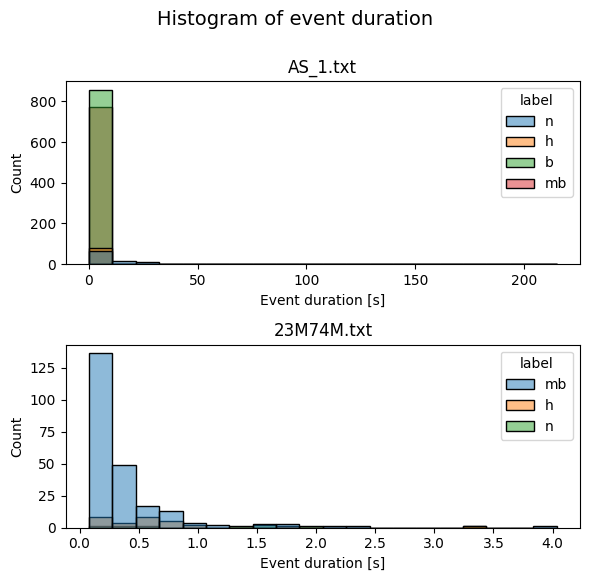

In [22]:
fig, axes = plt.subplots(2, 1, figsize=(6, 6))
for index, val in enumerate(zip([df1, df2], [ann1, ann2])):
    df = val[0]
    ann= val[1]

    # only keep labels of interest
    df_temp = df[df['label'].isin(['b', 'h', 'mb', 'n'])]

    sns.histplot(df_temp, x='duration', hue='label', ax=axes[index], bins=20)
    axes[index].set_xlabel('Event duration [s]')
    axes[index].set_title(ann.name)

fig.suptitle("Histogram of event duration", fontsize=14)
fig.tight_layout(rect=[0, 0.02, 1, 0.98])

# Save and show
save_path = FIGURES_DIR / "EDA_histogram_event_duration_all.png"
save_path.parent.mkdir(parents=True, exist_ok=True)
fig.savefig(save_path, dpi=150, bbox_inches="tight")
print(f"Saved figure to {save_path}")

Saved figure to D:\Files\Projects\Code\digehealth-assessment\reports\figures\EDA_histogram_event_duration_bowel_movements_.png


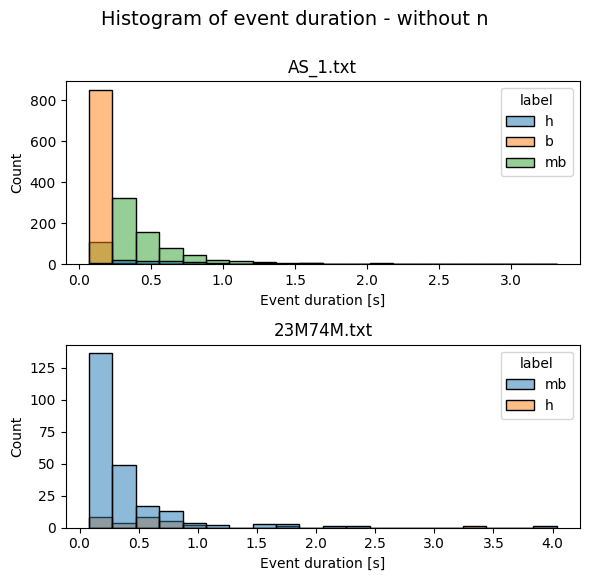

In [27]:
fig, axes = plt.subplots(2, 1, figsize=(6, 6))
for index, val in enumerate(zip([df1, df2], [ann1, ann2])):
    df = val[0]
    ann = val[1]

    # only keep labels of interest
    df_temp = df[df["label"].isin(["b", "h", "mb"])].copy()

    sns.histplot(df_temp, x="duration", hue="label", ax=axes[index], bins=20)
    axes[index].set_xlabel("Event duration [s]")
    axes[index].set_title(ann.name)

fig.suptitle("Histogram of event duration - without n", fontsize=14)
fig.tight_layout(rect=[0, 0.02, 1, 0.98])

# Save and show
save_path = FIGURES_DIR / "EDA_histogram_event_duration_bowel_movements_.png"
save_path.parent.mkdir(parents=True, exist_ok=True)
fig.savefig(save_path, dpi=150, bbox_inches="tight")
print(f"Saved figure to {save_path}")

# Observations:
- especially the mb bowel movements can vary much more significantly in length.
- No big differnce between the files